In [2]:
# All the imports we need
import numpy as np
import gtsam
from gtsam.utils.plot import plot_pose3
from matplotlib import pyplot as plt
from gtsam.symbol_shorthand import B, V, X
from gtbook.display import show
from mpl_toolkits.mplot3d import Axes3D

try:
  # For Google Colab
  from google.colab import output
  output.enable_custom_widget_manager()
  print(" -- Custom widgets enabled")
except:
  pass

# For interactive plots
%matplotlib widget

In [3]:
T = 12  # The timespan of our trajectory.
dt = 1e-2  # 100 Hz frequency
velocity = np.array([2, 0, 0])  # The velocity we wish to move at.

scenarios = {
    "zero_twist": (np.zeros(3), np.zeros(3)),  # Zero motion, stationary trajectory.
    "forward_motion": (np.zeros(3), velocity),  # Move forward in the x axis at 2 m/s.
    "loop": (np.array([0, -np.radians(30), 0]), velocity),  # A loop-de-loop trajectory.
    "sick": (np.array([np.radians(30), -np.radians(30), 0]), velocity)  # A spiral trajectory, "sick" in surfer slang.
}


def plot_scenario(scenario,
                  T,
                  dt,
                  title="IMU trajectory scenario",
                  fignum=0,
                  maxDim=5):
    for t in np.arange(0, T, dt):
        actualPose = scenario.pose(t)
        plot_pose3(fignum, actualPose, axis_length=0.3)

        translation = actualPose.translation()
        maxDim = max([max(np.abs(translation)), maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-maxDim, maxDim)
        ax.set_ylim3d(-maxDim, maxDim)
        ax.set_zlim3d(-maxDim, maxDim)
        ax.set_title(title)
    

    plt.show()

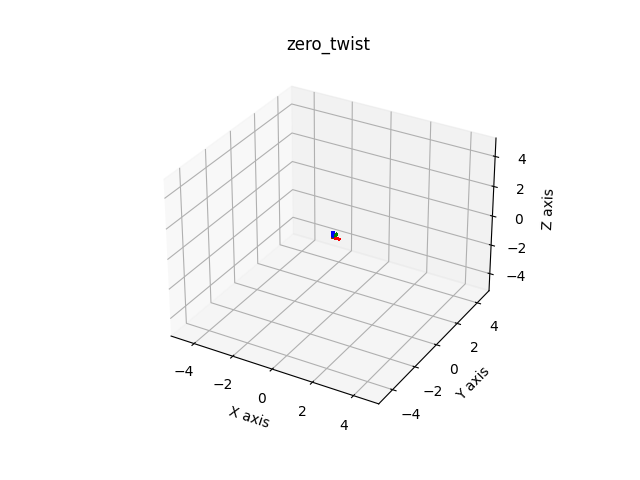

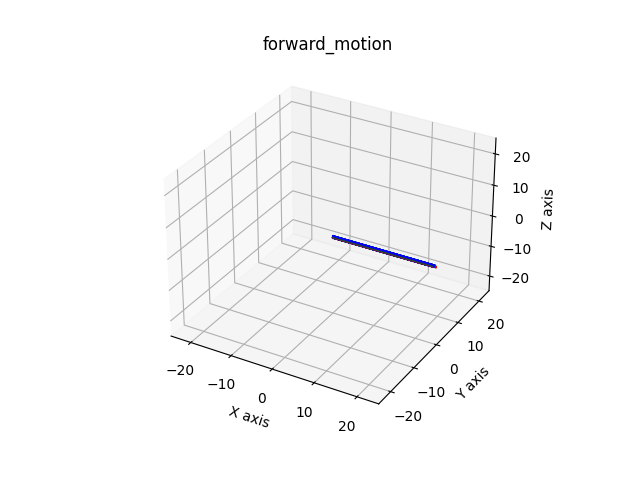

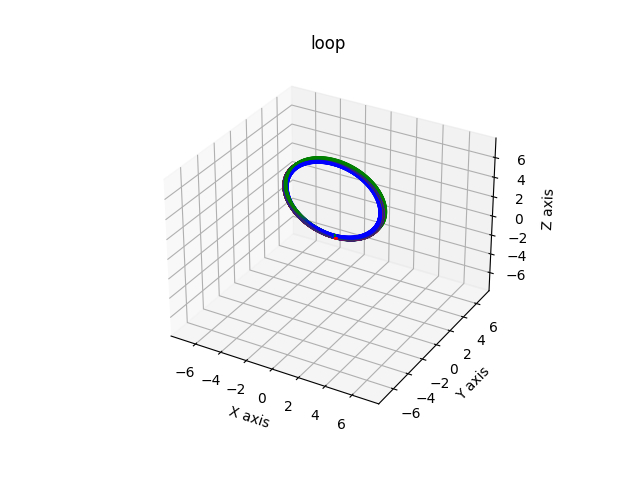

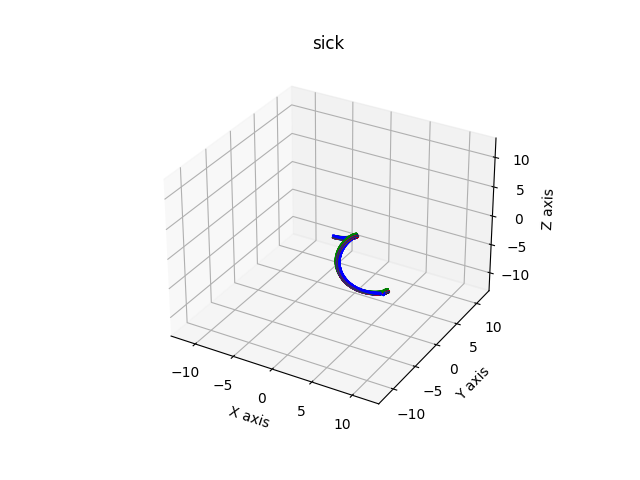

In [4]:
for idx, scenario_name in enumerate(scenarios.keys()):
    scenario = gtsam.ConstantTwistScenario(*scenarios[scenario_name])
    plot_scenario(scenario, T, dt, fignum=idx + 1, title=scenario_name)

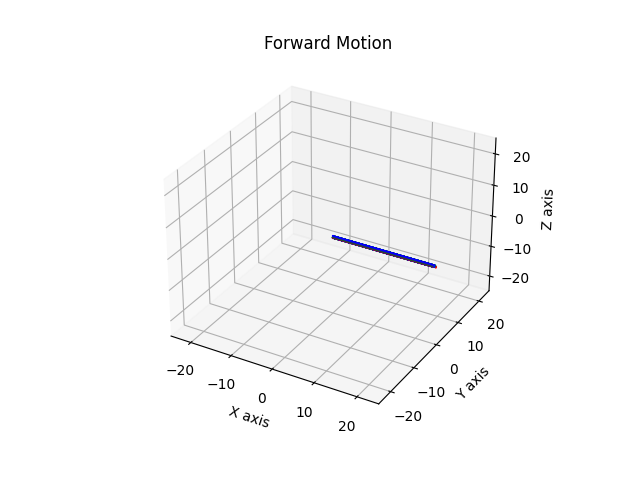

In [5]:
scenario = gtsam.ConstantTwistScenario(*scenarios["forward_motion"])

# Let's visualize it for our understanding
plot_scenario(scenario, T, dt, title="Forward Motion", fignum=5)

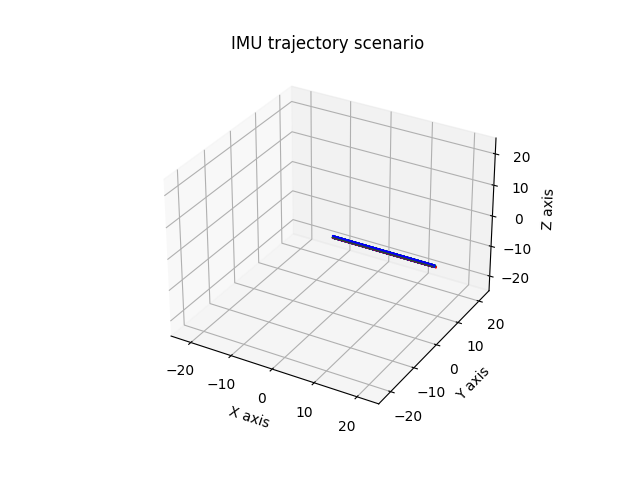

In [6]:
accBias = np.array([-0.3, 0.1, 0.2])
gyroBias = np.array([0.1, 0.3, -0.1])
actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

pim_params = gtsam.PreintegrationParams.MakeSharedU(9.81)


# Some arbitrary noise sigmas
gyro_sigma = 1e-3
accel_sigma = 1e-3
I_3x3 = np.eye(3)
pim_params.setGyroscopeCovariance(gyro_sigma**2 * I_3x3)
pim_params.setAccelerometerCovariance(accel_sigma**2 * I_3x3)
pim_params.setIntegrationCovariance(1e-7**2 * I_3x3)

# Define the PreintegratedImuMeasurements object here.
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)
plot_scenario(scenario, T, dt, fignum=6)

In [7]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

In [8]:
def add_priors(scenario, graph, initial):
    # Noise models for
    priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
    velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

    initial_state = scenario.navState(0)
    graph.push_back(
        gtsam.PriorFactorPose3(X(0), initial_state.pose(), priorNoise))
    graph.push_back(
        gtsam.PriorFactorVector(V(0), initial_state.velocity(), velNoise))

    initial.insert(B(0), actualBias)
    initial.insert(X(0), initial_state.pose())
    initial.insert(V(0), initial_state.velocity())

    return graph, initial


graph, initial = add_priors(scenario, graph, initial)


In [9]:
def main_loop(runner, scenario, graph, initial, T):
    # The factor index for the estimation rate
    i = 0

    for k, t in enumerate(np.arange(0, T, dt)):
        # get measurements and add them to PIM

        
        measuredOmega = runner.measuredAngularVelocity(t)
        measuredAcc = runner.measuredSpecificForce(t)

        ### This is where all the magic happens!
        pim.integrateMeasurement(measuredAcc, measuredOmega, dt)

        if (k + 1) % int(1 / dt) == 0:
            # Create IMU factor every second.
            factor = gtsam.ImuFactor(X(i), V(i), X(i + 1), V(i + 1), B(0), pim)
            graph.push_back(factor)

            # We have created the binary constraint, so we clear out the preintegration values.
            pim.resetIntegration()

            # Get the true state which we will corrupt with some additive noise terms defined below
            actual_state_i = scenario.navState(t + dt)

            # These are additive noise terms.
            rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
            translationNoise = gtsam.Point3(*np.random.randn(3) * 1)
            poseNoise = gtsam.Pose3(rotationNoise, translationNoise)

            noisy_state_i = gtsam.NavState(
                actual_state_i.pose().compose(poseNoise),
                actual_state_i.velocity() + np.random.randn(3) * 0.1)

            print(noisy_state_i)
            initial.insert(X(i + 1), noisy_state_i.pose())
            initial.insert(V(i + 1), noisy_state_i.velocity())
            i += 1
            

    return graph, initial

In [10]:
graph, initial = main_loop(runner, scenario, graph, initial, T)

R: [
	0.998584, 0.0323124, 0.0422578;
	-0.0374528, 0.991178, 0.127133;
	-0.037777, -0.128536, 0.990985
]
p: 0.793503 -2.13187 -1.48222
v:    2.06118 -0.0524511  0.0111571

R: [
	0.947551, 0.30441, 0.0973769;
	-0.297224, 0.951308, -0.0816729;
	-0.117498, 0.0484464, 0.991891
]
p:   3.96093 -0.307498 -0.947112
v:     1.88484 -0.00922076   -0.100242

R: [
	0.993943, -0.0472714, -0.0992105;
	0.0569971, 0.993592, 0.0976044;
	0.0939608, -0.102668, 0.990268
]
p:   6.26838  0.363875 -0.358985
v:   1.91902 0.0368647 -0.119645

R: [
	0.995235, -0.0929487, 0.0294635;
	0.0909003, 0.993765, 0.0645577;
	-0.0352804, -0.0615718, 0.997479
]
p:   8.62717 -0.275779  0.501415
v:   1.84655  -0.10478 0.0359046

R: [
	0.992473, -0.0996844, 0.0711416;
	0.0895064, 0.986905, 0.134189;
	-0.0835865, -0.126811, 0.988399
]
p:  11.2906  1.76589 -1.02787
v:   1.95881 0.0621317 -0.104664

R: [
	0.997124, 0.0134021, -0.074596;
	-0.0101279, 0.998976, 0.0440986;
	0.0751106, -0.0432162, 0.996238
]
p:  12.7795  1.57757 -1.4

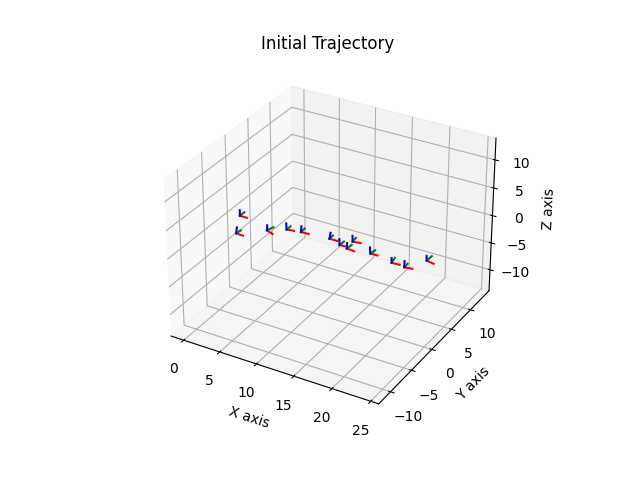

In [11]:
def plot_trajectory(values: gtsam.Values,
                    title: str = "Estimated Trajectory",
                    fignum: int = 1,
                    show: bool = False):
    i = 0
    while values.exists(X(i)):
        pose_i = values.atPose3(X(i))
        plot_pose3(fignum, pose_i, 1)
        i += 1
    plt.title(title)

    gtsam.utils.plot.set_axes_equal(fignum)

    plt.ioff()

    if show:
        plt.show()


plot_trajectory(initial, title="Initial Trajectory", fignum=7, show=True)

In [12]:
lm_params = gtsam.LevenbergMarquardtParams()
lm_params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

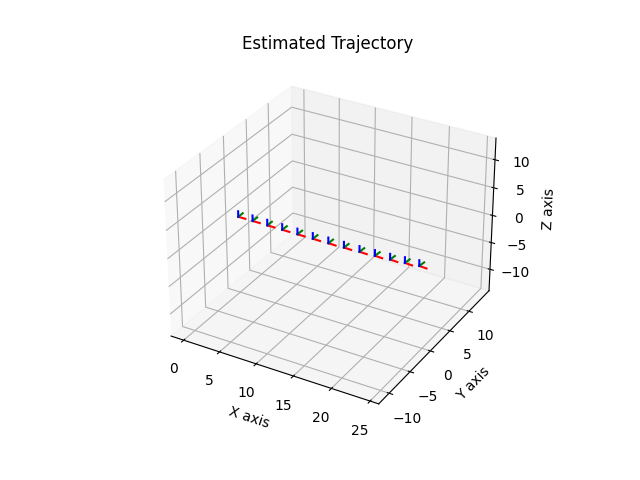

In [13]:
plot_trajectory(result, fignum=8, show=True)

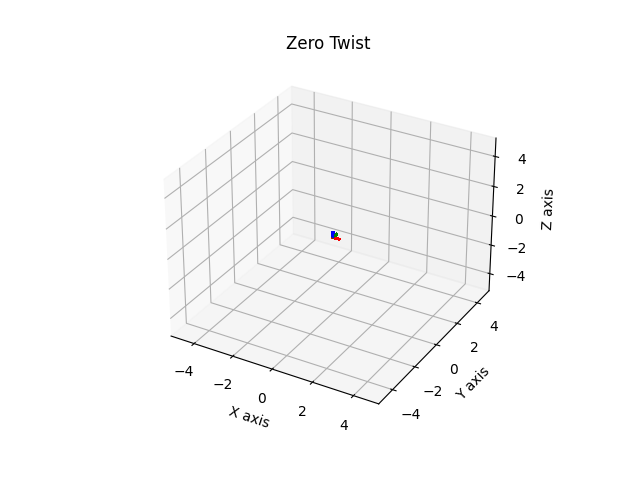

R: [
	0.998876, 0.0465532, 0.00896306;
	-0.0465235, 0.998911, -0.00349274;
	-0.00911589, 0.00307182, 0.999954
]
p: 0.433735  0.41755  1.30765
v: 0.00781187 -0.0840253 -0.0395038

R: [
	0.997912, 0.0461062, -0.045234;
	-0.0497246, 0.995355, -0.0824315;
	0.0412233, 0.0845086, 0.99557
]
p: -0.710192  0.289684 -0.355961
v:   0.118917 -0.0625402   0.179356

R: [
	0.98082, 0.191872, -0.0343197;
	-0.194847, 0.969881, -0.146171;
	0.0052398, 0.150055, 0.988664
]
p:  0.477232 -0.966093  0.224075
v: -0.00664929   0.0628126   -0.235342

R: [
	0.997929, -0.019867, -0.0611755;
	0.0265115, 0.993601, 0.109796;
	0.0586027, -0.11119, 0.99207
]
p:   0.640073 -0.0837357 0.00258667
v: -0.00964568  -0.0567342    0.022708

R: [
	0.99152, 0.085357, -0.0979952;
	-0.0795716, 0.99493, 0.0615078;
	0.102748, -0.0531886, 0.993284
]
p:   1.29599  -1.30519 -0.370169
v: -0.00823941   0.0751391 -0.00921402

R: [
	0.994356, -0.0415373, -0.0976267;
	0.0479628, 0.99677, 0.0644179;
	0.0946356, -0.0687368, 0.993136
]
p:  0.

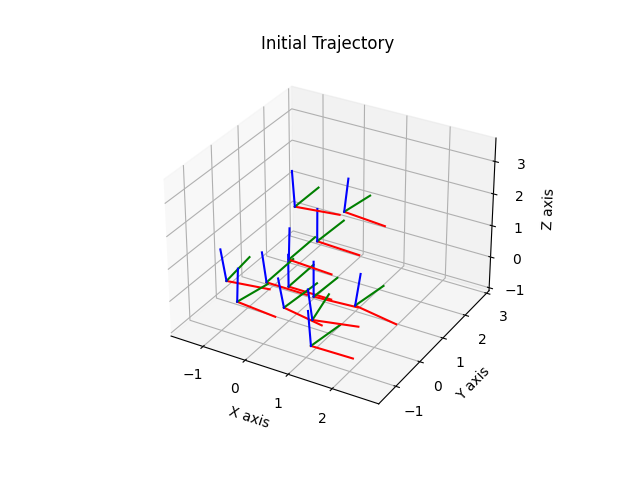

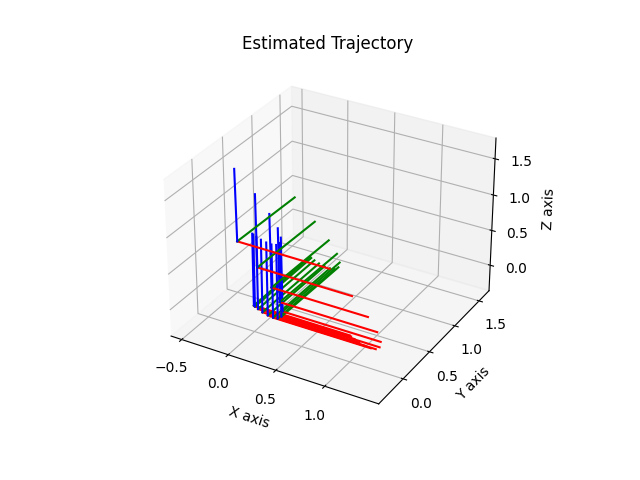

In [14]:
scenario = gtsam.ConstantTwistScenario(*scenarios["zero_twist"])
plot_scenario(scenario, T, dt, title="Zero Twist", fignum=9)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

graph, initial = add_priors(scenario, graph, initial)
graph, initial = main_loop(runner, scenario, graph, initial, T)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

plot_trajectory(initial, title="Initial Trajectory", fignum=10, show=True)
plot_trajectory(result, fignum=11, show=True)

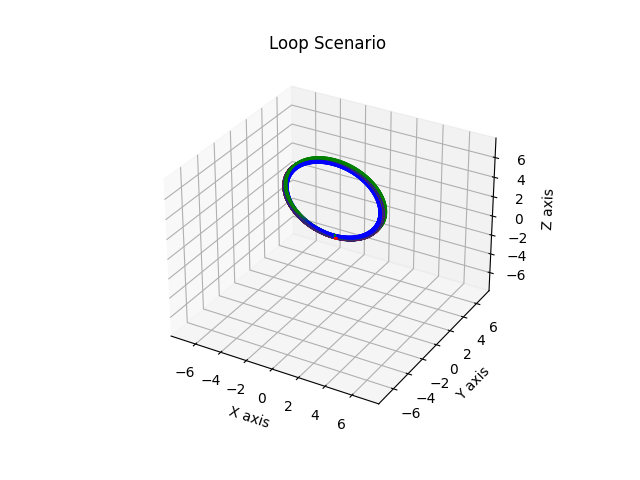

R: [
	0.796386, -0.0988559, -0.596655;
	0.112957, 0.993503, -0.0138376;
	0.594147, -0.0563765, 0.802378
]
p: 0.649222  1.24174 -1.06158
v:  1.77214 0.170909   1.0083

R: [
	0.367077, 0.0593071, -0.928298;
	0.0924764, 0.990695, 0.0998614;
	0.925582, -0.122502, 0.358176
]
p: 1.80638 0.34254 2.43161
v: 0.950968   0.1212  1.77895

R: [
	0.0731322, -0.0391397, -0.996554;
	0.0629901, 0.997416, -0.034551;
	0.995331, -0.0602463, 0.0754086
]
p:  2.46933 0.868321  5.22559
v:  0.163224 0.0560799   1.94877

R: [
	-0.382263, 0.0618652, -0.921981;
	0.0160847, 0.998051, 0.0603006;
	0.923914, 0.00822082, -0.382512
]
p:   3.39059 0.0160992   4.61958
v:   -1.02324 -0.0303163     1.8862

R: [
	-0.807814, -0.0439546, -0.587797;
	0.0162453, 0.995177, -0.0967439;
	0.589214, -0.0876999, -0.803203
]
p: 0.603182    1.636  6.59182
v:  -1.92162 0.0532573  0.982242

R: [
	-0.997856, 0.0412665, -0.0507894;
	0.0407192, 0.999101, 0.0117634;
	0.0512291, 0.00967012, -0.99864
]
p:   1.24889 -0.829632   7.31295
v:  -2.0

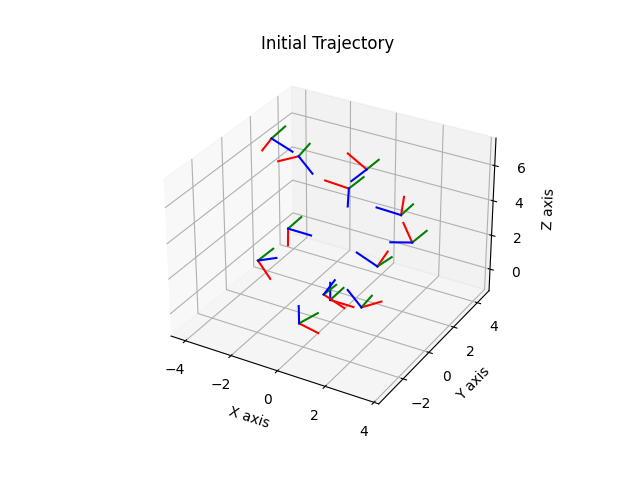

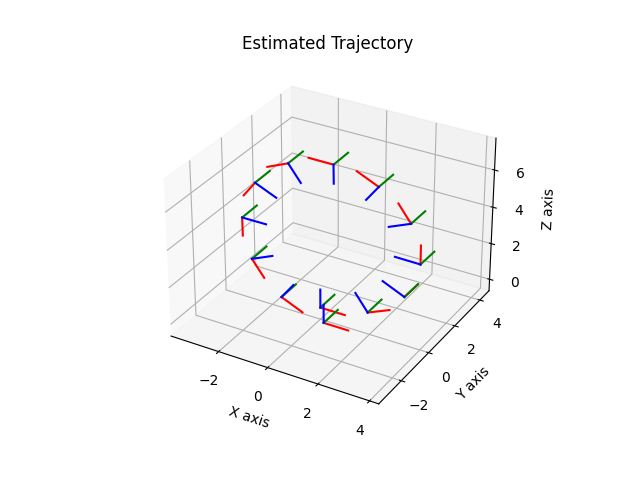

In [15]:
scenario = gtsam.ConstantTwistScenario(*scenarios["loop"])
plot_scenario(scenario, T, dt, title="Loop Scenario", fignum=12)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

graph, initial = add_priors(scenario, graph, initial)
graph, initial = main_loop(runner, scenario, graph, initial, T)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

plot_trajectory(initial, title="Initial Trajectory", fignum=13, show=True)
plot_trajectory(result, fignum=14, show=True)

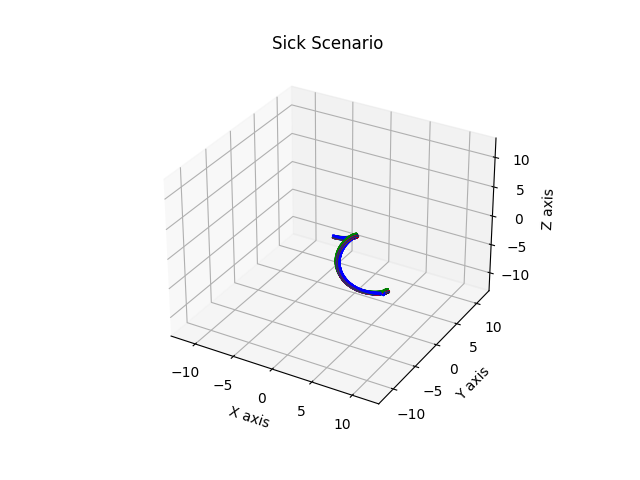

R: [
	0.812421, -0.184526, -0.553102;
	-0.134764, 0.863492, -0.486025;
	0.567284, 0.469395, 0.676651
]
p:  2.31059 -1.01109  0.43289
v:   1.79862 -0.082034   0.90067

R: [
	0.597747, -0.474768, -0.645982;
	-0.40528, 0.516276, -0.754458;
	0.691698, 0.712779, 0.116188
]
p:  3.43324 -1.54334  2.64209
v:  1.11728 -1.07064  1.47163

R: [
	0.360744, -0.803006, -0.474389;
	-0.811396, -0.0194021, -0.584175;
	0.459892, 0.595655, -0.658555
]
p:  3.57839 -1.55468  2.36829
v: 0.475287 -1.57813  1.10018

R: [
	-0.0214991, -0.999693, -0.0123564;
	-0.999158, 0.0219164, -0.03469;
	0.0349501, 0.0116002, -0.999322
]
p:  4.61467 -5.29715   3.7048
v: 0.190639 -1.98762 0.122102

R: [
	-0.010718, -0.93833, 0.345575;
	-0.885964, 0.169148, 0.431806;
	-0.46363, -0.301539, -0.83314
]
p:  6.48117 -4.94657   2.9123
v:  0.320298  -1.99667 -0.770907

R: [
	0.299199, -0.616676, 0.728142;
	-0.687592, 0.389753, 0.612626;
	-0.661587, -0.683961, -0.307407
]
p:  4.14867 -7.68492  1.62467
v: 0.878769 -1.29799 -1.44876

R:

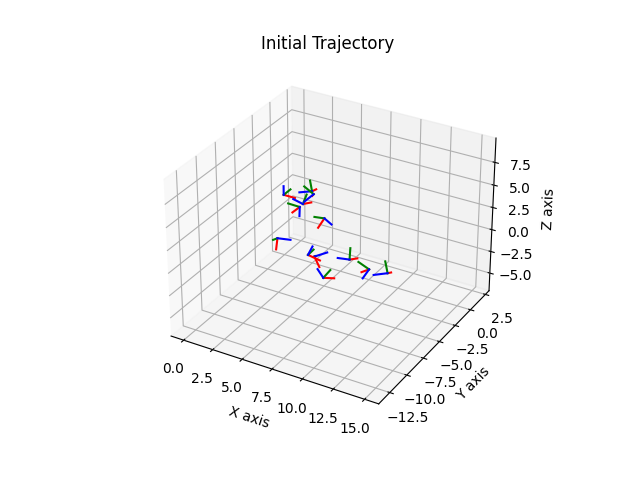

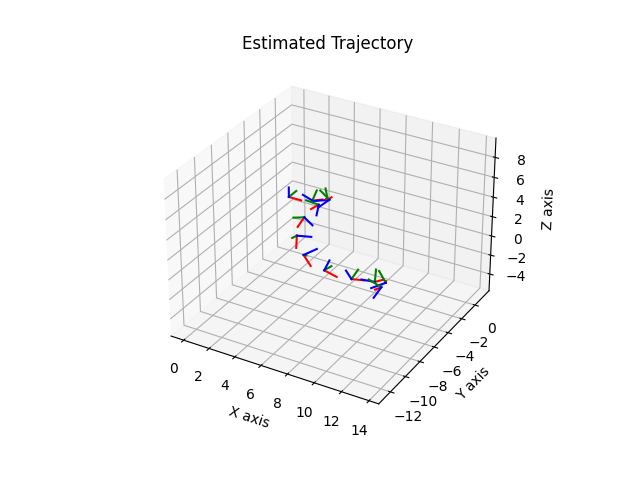

In [16]:
scenario = gtsam.ConstantTwistScenario(*scenarios["sick"])
plot_scenario(scenario, T, dt, title="Sick Scenario", fignum=15)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

graph, initial = add_priors(scenario, graph, initial)
graph, initial = main_loop(runner, scenario, graph, initial, T)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

plot_trajectory(initial, title="Initial Trajectory", fignum=16, show=True)
plot_trajectory(result, fignum=17, show=True)